# Project Milestone One: Gathering your Team, Understanding the Problem,  Exploring the Data

#### Due: Midnight on July 20th (with 2-hour grace period)

#### There will be no late period on this homework, as we need to start manual grading immediately! 



### What We Will Do in This Milestone Assignment

1. You will convene your team and fill out the Team Contract (in the Homework Repo), to be submitted to Gradescope.
2. You must select a team leader for the purpose of submitting this notebook, after the team collaborates to complete the assignment. This <a href=https://guides.gradescope.com/hc/en-us/articles/21863861823373-Adding-Group-Members-to-a-Submission>link</a> describes how to add group members to your leader's submission. 
3. At the conclusion of your work on this Milestone, you will complete an Individual Evaluation of your team's work (in the Homework Repo) and upload it *individually* to Gradescope.
4. We will follow a simplified version of the **Machine Learning Project Checklist** in Appendix A in our textbook *Hands-On Machine Learning* (pp.779):  

>Part 1:	Frame the problem and look at the big picture  
Part 2: Download and perform preliminary exploration of the data  
Part 3: Clean the Data: Drop, Impute, and Encode   
Part 4: Explore Feature Relationships  
Part 5: Investigate Feature Engineering options to better expose the underlying data patterns  

### The Dataset

All teams will use the same dataset. It is a smaller version of the Zillow housing dataset that was used in the
Zillow Million Dollar Prize which ran on Kaggle in 2017 (sorry, the contest is closed, so you can't win any money
with this project!).  We will try to predict the assessed tax value (`'taxvaluedollarcnt'`) of the property from a large collection
of descriptors. Some features are closely related and some are obviously useless.  There are potential outliers and also quite a few missing values. 

This is a good example of a dataset which has not been predigested for you on Kaggle, and should give you a good chance to
try all the various tools in your toolbox!


In [1]:
!pip3 install tqdm

# =============================
# Useful Imports
# =============================

# Standard Libraries
import os
import time
import math
import io
import zipfile
import requests
from urllib.parse import urlparse
from itertools import chain, combinations

# Data Science Libraries
import numpy as np
import pandas as pd
import seaborn as sns

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as mticker  # Optional: Format y-axis labels as dollars

# Scikit-learn (Machine Learning)
from sklearn.model_selection import (
    train_test_split, 
    cross_val_score, 
    GridSearchCV, 
    RandomizedSearchCV, 
    RepeatedKFold
)
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector, f_regression, SelectKBest
from sklearn.datasets import make_regression
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor

# Kaggle and Progress Tracking
from tqdm import tqdm

# =============================
# Global Variables
# =============================
random_state = 42

# =============================
# Utility Functions
# =============================

# Format y-axis labels as dollars with commas (optional)
def dollar_format(x, pos):
    return f'${x:,.0f}'

# Convert seconds to HH:MM:SS format
def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds)) 


## Prelude: Download the Zillow Housing Dataset 

The code cell below will load the dataset for you.    

> **Notice that before downloading, this cell first checks whether the files already exist.** 

For a detailed description of the dataset features, please refer to  **Appendix 1** below. 

**Note:** Do **not** perform a train/test split for this milestone (unlike HOML suggests), since you need to do the split **after** any data preparation and feature engineering. You can wait until Milestone 2 to do the split. 

In [2]:
import os
import requests
import pandas as pd
from urllib.parse import urlparse

url = "https://www.cs.bu.edu/fac/snyder/cs505/Data/zillow_dataset.csv"

filename = os.path.basename(urlparse(url).path)

if not os.path.exists(filename):
    try:
        print("Downloading the file...")
        response = requests.get(url)
        response.raise_for_status()  # Raise an error for bad status codes
        with open(filename, "wb") as f:
            f.write(response.content)
        print("File downloaded successfully.")
    except requests.exceptions.RequestException as e:
        print(f"Error downloading the file: {e}")
else:
    print("File already exists. Skipping download.")

df = pd.read_csv(filename) 

File already exists. Skipping download.


## Part 1: Frame the problem and look at the big picture [3 pts]

This part is a bit vague, since this project is not taking place in an actual business, but for the sake of exercizing all the steps, **pretend** that you are working at Zillow as a data analyst and are given this dataset and asked to
- Analyze and understand the data; 
- Create a regression model;
- Give a presentation to the marketing team about your results.  

#### **1 Discussion:** 

AFTER doing your EDA, come back and answer each of the following 3 questions in a *concise and informative paragraph between the lines;* you may wish to use your own business or home-buying experience, or to do some online research about the issues before you propose your ideas. (Don't stress about this, but *humor your professor and give it your best shot!*)


**1.1:**  What is the objective of this project in business terms?


The goal of this project is to help Zillow learn which home features have the strongest impact on tax-assessed values. With this knowledge, Zillow can make its price estimates, like the Zestimate, more accurate and reliable for users. Better predictions can help buyers and sellers make smarter decisions and allow Zillow’s marketing team to focus their efforts on the most valuable types of homes or areas. Overall, we want our project to turn the data into insights that help Zillow improve its tools, marketing strategies, and customer experience.

**1.2:**  How will your solution be used?


we expect our solution to help Zillow in several ways. First, the regression model we build will show which property features, like square footage, number of bedrooms, or location, have the biggest impact on tax-assessed values. This information can help Zillow improve the accuracy of its home price estimates on the website, making tools like the Zestimate more reliable for users. Second, our analysis can give the marketing team insights into which types of homes or regions to focus on in advertising and promotions, helping Zillow attract more users and clients. Finally, our findings could be shared with buyers, sellers, and real estate professionals to help them make more informed decisions. Overall, our goal is for our project to provide both technical value through the predictive model and practical business insights for Zillow’s teams.

**1.3:**  How should success (or failure) be measured?


We would measure success by how well our model can predict the actual tax-assessed values of the houses. We will use metrics like RMSE or MAE to check how close our predictions are to the real numbers. The lower these errors, the better. Success also means our analysis helps Zillow figure out which features really influence home prices. On the other hand, we would consider it a failure if our model makes big mistakes or doesn’t provide any useful insights for the business.

## Part 2: Download and perform preliminary exploration of the data [4 pts]

### Part 2.A: Load the data into a dataframe and study each feature/column and its characteristics:
- Name
- Type (categorical, int/float, text, etc.)
- Apparent usefulness for the task
- Approximate % of missing values
- How many unique values

**Note:** The **target** is the last column `'taxvaluedollarcnt'` -- pay particular attention to this during the EDA process. 
  
Hint: Just use `.head()`, `.info()`, and `.nunique()`.

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,assessmentyear,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,taxvaluedollarcnt
0,14297519,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,NaN,...,NaN,NaN,1998.0,NaN,NaN,2016.0,NaN,NaN,6.059063e+13,1023282.0
1,17052889,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,NaN,...,NaN,NaN,1967.0,1.0,NaN,2016.0,NaN,NaN,6.111001e+13,464000.0
2,14186244,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,NaN,...,NaN,NaN,1962.0,1.0,NaN,2016.0,NaN,NaN,6.059022e+13,564778.0
3,12177905,NaN,NaN,NaN,3.0,4.0,NaN,8.0,3.0,NaN,...,NaN,NaN,1970.0,NaN,NaN,2016.0,NaN,NaN,6.037300e+13,145143.0
4,10887214,1.0,NaN,NaN,3.0,3.0,NaN,8.0,3.0,NaN,...,NaN,NaN,1964.0,NaN,NaN,2016.0,NaN,NaN,6.037124e+13,119407.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77613 entries, 0 to 77612
Data columns (total 55 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      77613 non-null  int64  
 1   airconditioningtypeid         25007 non-null  float64
 2   architecturalstyletypeid      207 non-null    float64
 3   basementsqft                  50 non-null     float64
 4   bathroomcnt                   77579 non-null  float64
 5   bedroomcnt                    77579 non-null  float64
 6   buildingclasstypeid           15 non-null     float64
 7   buildingqualitytypeid         49809 non-null  float64
 8   calculatedbathnbr             76963 non-null  float64
 9   decktypeid                    614 non-null    float64
 10  finishedfloor1squarefeet      6037 non-null   float64
 11  calculatedfinishedsquarefeet  77378 non-null  float64
 12  finishedsquarefeet12          73923 non-null  float64
 13  f

,Name,Type,Missing %,Unique Values,Apparent Usefulness
6,buildingclasstypeid,float64,100.0,2,Needs review
3,basementsqft,float64,99.9,43,Needs review
13,finishedsquarefeet13,float64,99.9,13,Needs review
41,storytypeid,float64,99.9,1,Needs review
46,yardbuildingsqft26,float64,99.9,59,Needs review
49,fireplaceflag,object,99.8,1,Needs review
2,architecturalstyletypeid,float64,99.7,5,Needs review
43,typeconstructiontypeid,float64,99.7,4,Needs review
16,finishedsquarefeet6,float64,99.5,350,Needs review
29,pooltypeid10,float64,99.4,1,Needs review


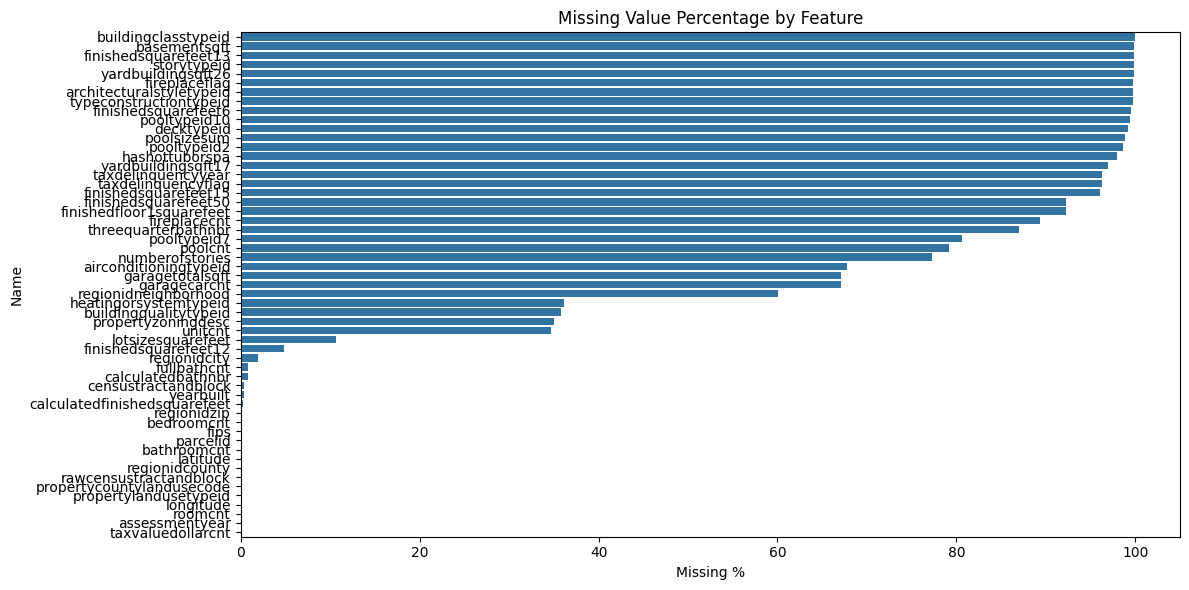

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('zillow_dataset.csv')
display(df.head())
df.info()
unique_counts = df.nunique()
missing_percent = df.isnull().mean().round(3) * 100
summary = pd.DataFrame({
    'Type': df.dtypes,
    'Missing %': missing_percent,
    'Unique Values': unique_counts
})
summary['Apparent Usefulness'] = summary.index.map(
    lambda col: 'Target' if col == 'taxvaluedollarcnt'
    else 'Potentially useful' if df[col].dtype in ['float64', 'int64'] and missing_percent[col] < 50
    else 'Needs review'
)
summary.reset_index(inplace=True)
summary.rename(columns={'index': 'Name'}, inplace=True)
display(summary.sort_values('Missing %', ascending=False))
plt.figure(figsize=(12, 6))
sns.barplot(data=summary.sort_values('Missing %', ascending=False), x='Missing %', y='Name')
plt.title('Missing Value Percentage by Feature')
plt.tight_layout()
plt.show() 

#### **2.A Discussion:** Answer the following questions.

**2.A.1:**  Which features are categorical?

In [6]:
df.select_dtypes(include=['object']).columns.tolist() 

['hashottuborspa',
 'propertycountylandusecode',
 'propertyzoningdesc',
 'fireplaceflag',
 'taxdelinquencyflag']

### Categorical features

### Object-type columns:

hashottuborspa

propertycountylandusecode

propertyzoningdesc

fireplaceflag

taxdelinquencyflag

### Numeric columns that represent categories:

airconditioningtypeid

architecturalstyletypeid

buildingclasstypeid

buildingqualitytypeid

decktypeid

fips (county code)

heatingorsystemtypeid

propertylandusetypeid

regionidcity

regionidcounty

regionidzip

storytypeid

typeconstructiontypeid

assessmentyear (only has 1 unique value, not useful, but technically categorical)

taxdelinquencyyear (year a property was tax delinquent, often treated as a category)

**2.A.2:**  Are there any features which appear at first glance to be **useless** for the business purpose of this project and should be deleted?  Give examples and describe your reasoning briefly. 

Yes, there are a number of features that appear useless or uninformative for the business goal of predicting property tax value. These include:

### Features with extremely high missingness (over 99%):
These features have almost no data and are unlikely to provide reliable signals:

buildingclasstypeid (100% missing)

basementsqft (99.9%)

finishedsquarefeet13 (99.9%)

storytypeid (99.9%)

fireplaceflag (99.8%)

pooltypeid10, pooltypeid2, pooltypeid7 (98–80%)

decktypeid (99.2%)

### Reason

These are too sparse to impute reliably and don't apply to most homes.

### Flags with only 1 unique value:

fireplaceflag (only 1 unique value)

taxdelinquencyflag (mostly null, only one value when present)

hashottuborspa (almost all missing, only one value)

### Reason

No variability = no predictive power.

### ID-like columns that don’t carry useful information:

parcelid: Unique ID for each property

censustractandblock and rawcensustractandblock: Geographic identifiers with many unique values

### Reason

These serve as identifiers, not predictors. Including them may cause overfitting.

### Columns with unclear business value:

assessmentyear: Only one unique value (2016)

taxdelinquencyyear: Mostly missing, could be useful only if many values present (not in this cas

**2.A.3:**  Are there any features which appear to be **useless** because of the percentage of missing values?  If so, give an example. 

Yes, some features are likely useless because they have over 99% missing values. 

Example: basementsqft
Missing %: 99.9%

### Reason

This feature is nearly always missing, which means we can't reliably impute or use it. It likely only applies to a very small subset of properties with basements and doesn't generalize well.

**2.A.4:**  Are there any features which appear to be **useless** because of the number of unique values?  If so, give an example. 

Yes, some features appear useless due to having an extremely high number of unique values, which likely represent IDs or overly granular information that doesn't generalize well. These features are unlikely to help with predicting home value and may even harm the model due to overfitting. 

### Example: parcelid

Unique values: 77,414 (almost 1:1 with the number of rows)

### Reason 

This is a unique identifier for each property and doesn't provide any meaningful pattern for prediction. It will only confuse the model.

Other high-uniqueness examples:

censustractandblock (39,006 unique values)

rawcensustractandblock (39,188 unique values)

latitude and longitude (each with 62k+ unique values)

### Part 2.B: Exploratory Data Analysis (EDA) -- Feature-Level Visualization  

- To get an overview, generate histograms for all features using `df.hist()`  (Hint: increase the figsize and set the layout to `(-1,m)` to get  `m` columns and as many rows as necessary.)
- Generate individual visualizations for the **target and three (3)** other interesting-looking features in the dataset (i.e., a total of 4):  
    - Use appropriate plot types (e.g., histograms and boxplots for numerical features, bar plots for categorical features) to understand distributions and identify potential outliers for these three.
    - Use as many code cells as you need, and give comments describing what each cell does.
    - Answer the discussion question posed (you should choose 3 features for which you can say something interesting in the discussion).

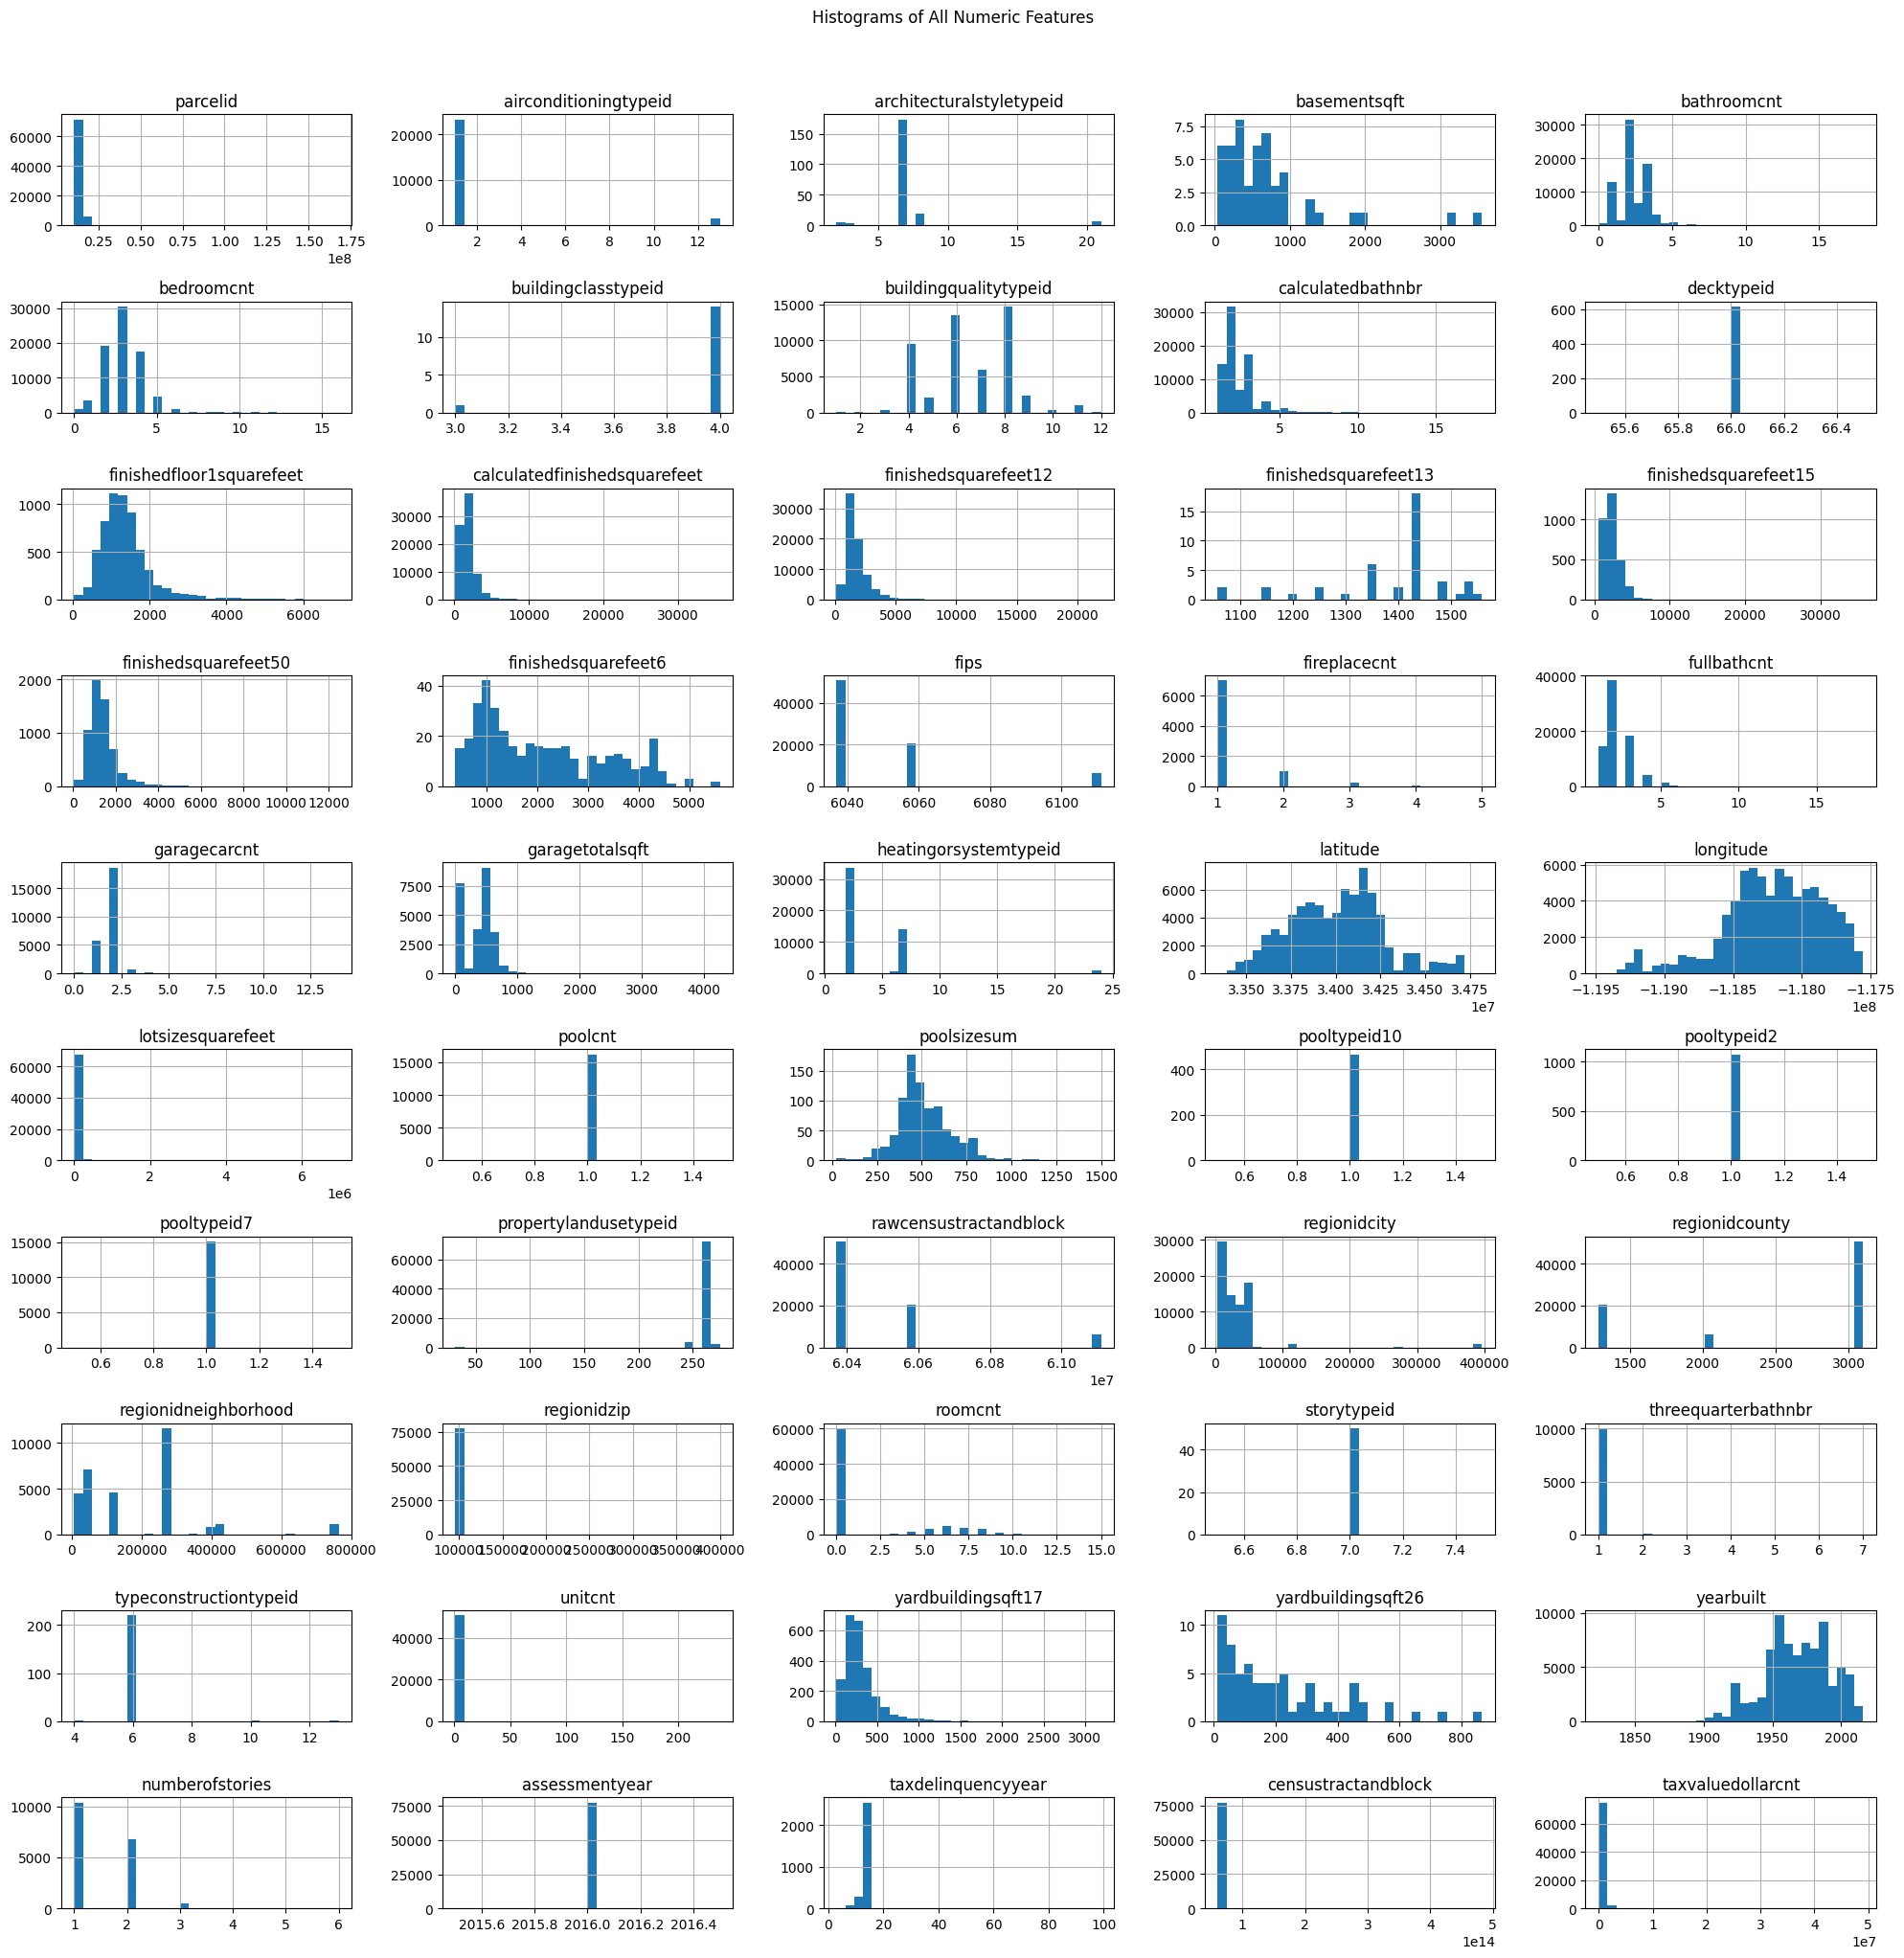

In [12]:
import matplotlib.pyplot as plt

df.hist(figsize=(20, 20), layout=(-1, 5), bins=30)
plt.suptitle('Histograms of All Numeric Features', y=1.02)
plt.tight_layout()
plt.show() 

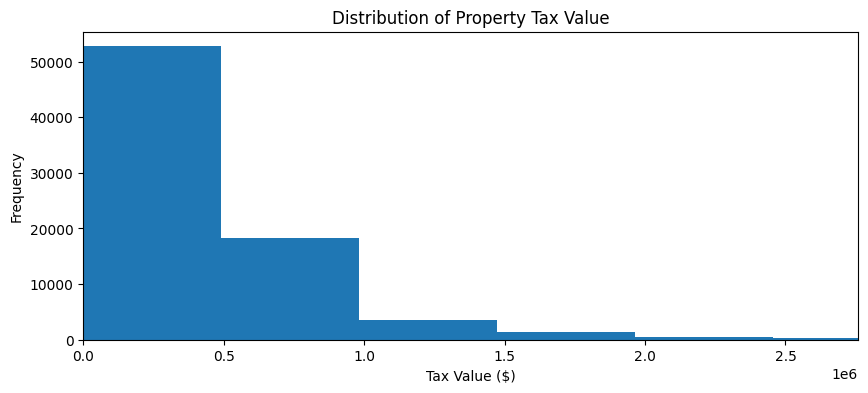

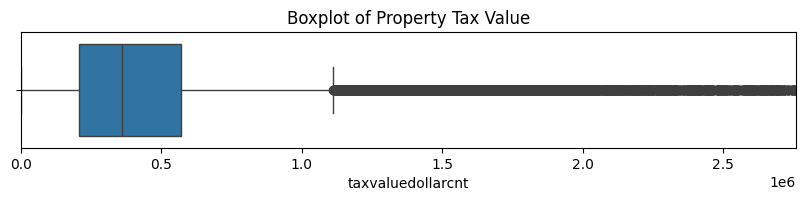

In [13]:
plt.figure(figsize=(10, 4))
df['taxvaluedollarcnt'].hist(bins=100)
plt.title('Distribution of Property Tax Value')
plt.xlabel('Tax Value ($)')
plt.ylabel('Frequency')
plt.xlim(0, df['taxvaluedollarcnt'].quantile(0.99))  # Focus on the 99th percentile
plt.grid(False)
plt.show() 

plt.figure(figsize=(10, 1.5))
import seaborn as sns
sns.boxplot(x=df['taxvaluedollarcnt'])
plt.xlim(0, df['taxvaluedollarcnt'].quantile(0.99))
plt.title('Boxplot of Property Tax Value')
plt.show() 

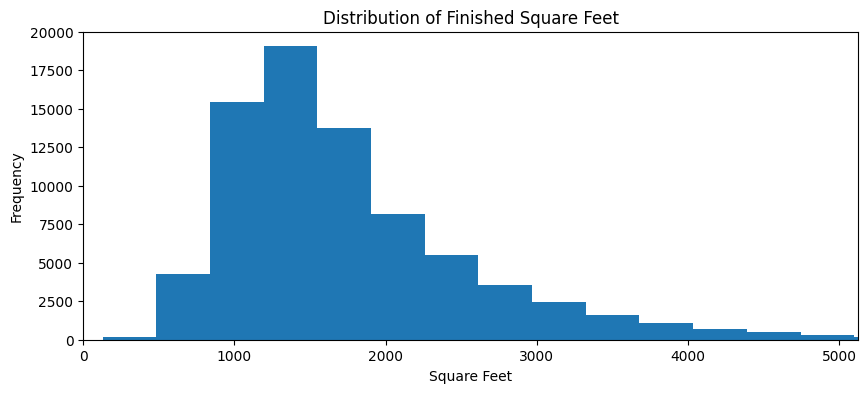

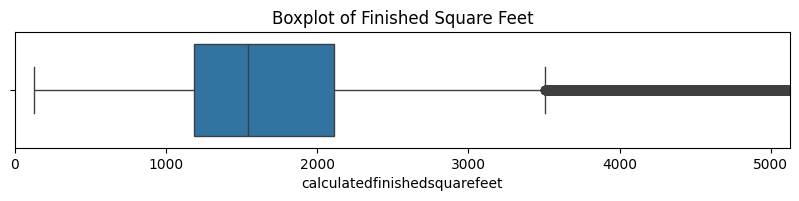

In [14]:
plt.figure(figsize=(10, 4))
df['calculatedfinishedsquarefeet'].dropna().hist(bins=100)
plt.title('Distribution of Finished Square Feet')
plt.xlabel('Square Feet')
plt.ylabel('Frequency')
plt.xlim(0, df['calculatedfinishedsquarefeet'].quantile(0.99))
plt.grid(False)
plt.show()

plt.figure(figsize=(10, 1.5))
sns.boxplot(x=df['calculatedfinishedsquarefeet'])
plt.xlim(0, df['calculatedfinishedsquarefeet'].quantile(0.99))
plt.title('Boxplot of Finished Square Feet')
plt.show() 

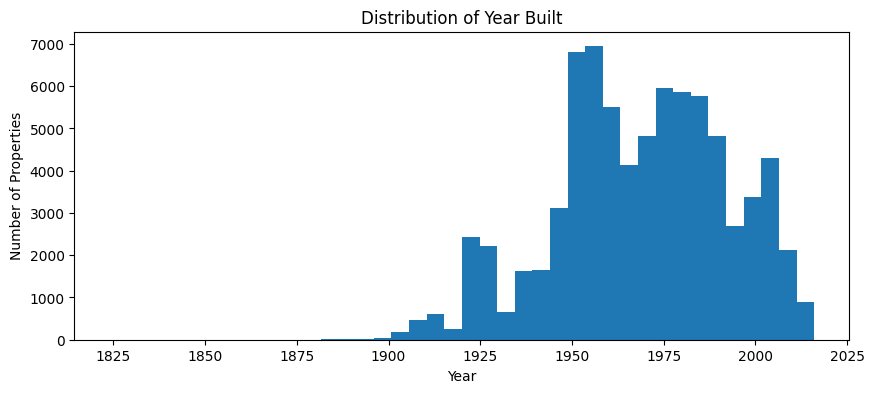

In [15]:
plt.figure(figsize=(10, 4))
df['yearbuilt'].dropna().astype(int).hist(bins=40)
plt.title('Distribution of Year Built')
plt.xlabel('Year')
plt.ylabel('Number of Properties')
plt.grid(False)
plt.show() 

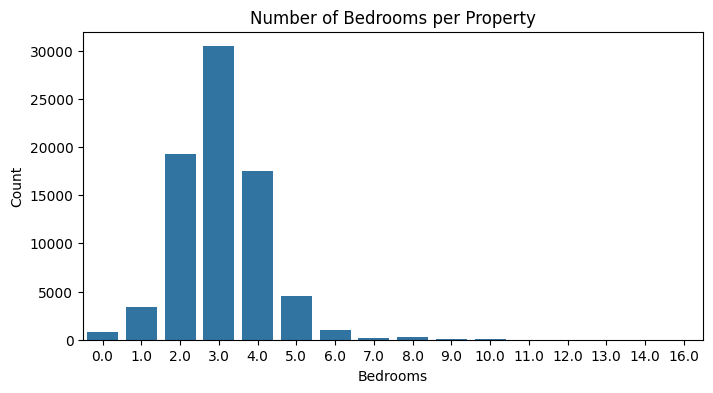

In [16]:
plt.figure(figsize=(8, 4))
sns.countplot(x='bedroomcnt', data=df)
plt.title('Number of Bedrooms per Property')
plt.xlabel('Bedrooms')
plt.ylabel('Count')
plt.grid(False)
plt.show() 

### Observation in the distributions of the target and three features we chose: 

### Tax value dollar cnt: 

The distribution is highly right-skewed, with most properties having values under $1 million. There are extreme outliers on the high end, which could represent luxury properties and may require transformation or clipping for modeling.

### Calculated finished square feet: 

Also right-skewed, most homes are between 1,000–3,000 sq ft. The long tail suggests some unusually large properties, likely commercial or luxury homes, which may need special treatment or exclusion.

### year built: 

Most homes were built after 1950, with development peaks around the 1960s and early 2000s. Older homes may have lower tax values unless renovated.

### bedroom cnt: 

Most properties have 2 to 4 bedrooms. Properties with more than 6 bedrooms are very rare and may be outliers or non-standard homes (e.g., multifamily or group housing) 

#### **2.B Discussion:** Describe in a paragraph what you learned in your detailed examination of the features you explored:
- What is the distribution (normal, exponential, etc.) if any?
- Any problems (e.g., outliers, any odd characteristics)?
- Anything else interesting? Why did you choose it?


In our detailed exploration of the target variable taxvaluedollarcnt and three features—calculatedfinishedsquarefeet, yearbuilt, and bedroomcnt. We observed that most of the distributions are right-skewed, resembling exponential or long-tailed distributions rather than normal ones. The tax value and finished square feet features both showed extreme high-end outliers, likely representing luxury or commercial properties, which could negatively impact model performance if not handled properly. The yearbuilt feature revealed peaks around common housing development periods, particularly post-1950, with very few homes built before 1900. The bedroomcnt feature displayed a reasonable distribution, with most properties having 2 to 4 bedrooms, but also included rare cases with more than 6 bedrooms that could indicate outliers or non-standard properties. We chose these features because they are likely to be strong predictors of property value and offered a useful mix of numeric and categorical characteristics to evaluate.

## Part 3:  Clean the Data: Drop, Impute, and Encode [6 pts]



**Important Notes:**
- You should review your Homework 4 before doing this section!
- Create new names for modified data at each stage to avoid problems with global variables.
- Whenever possible, write functions for all data transformations you apply, for these reasons:
    - So you can easily prepare the data the next time you get a fresh dataset
    - So you can apply these transformations in future projects
    - To clean and prepare new data instances once your solution is live
    - To make it easy to treat your preparation choices as hyperparameters
    - [To apply the same transformations to your test set if train/test split already done -- not applicable here] 

### Part 3.A: Drop features you judge to be unsuitable for the regression task

Your call, based on any research you can do to understand the feature (hopefully IRL you would have a domain expert to help with this, but do your best).   

Note: Do not drop features because of too many missing values, that's the next task! 

#### **3.A Discussion:** Justify in a paragraph your decisions about which features to drop. 


### Part 3.B: Drop **features** with "too many" null values

Your code in the next cell(s). Make a judgement call about what "too many" means and briefly describe your reasoning in the discussion.   

Note: "Too many" may depend on what the non-null values look like, be sure to investigate carefully. 

#### **3.B Discussion:** In a paragraph, explain your decision about which features were dropped



### Part 3.C: Drop Problematic **samples** 

There could be several reasons why you might want to drop a sample:
- It has  "too many" null values 
- It has a null value in the target
- It contains outliers, especially in the target



Your code in the next cell(s). Make a judgement call about which samples should be dropped and briefly describe your reasoning in the discussion.   


#### **3.C Discussion:** In a short paragraph, explain your decision about which samples were dropped


### Part 3.D: Impute for the remaining missing values

Review the methods for imputation in **Appendix 2** and choose how you will impute the remainder of the missing values. Note:
- Consider whether different methods are justified for different features.
- In the next cells, apply your imputation methods to the dataset so that no null values remain after this step.
- Answer the discussion question.

#### **3.D Discussion:**  Describe in a paragraph your decisions about which methods you used to impute missing values in the dataset


### 3.E: Encode the Categorical Features (if any)

You may not have any categorical features. If you do, encode them in the next step. No discussion is necessary. 

## Part 4:  Investigate Feature Relationships  [6 pts]

In this part, we will investigate the feature relationships as a way of understanding the data.  In the next part, we'll investigate potential feature engineering opportunities.

**Note:**  We won't be committing to any changes to the data until Milestone 2, as our choice of transformations will very much depend on the model we're building. But investigating these aspects of the data is an essential step in the first stages of our project. 

### Part 4.A:

   - Compute and analyze pairwise correlations using a correlation matrix.
   - Compute the F-statistic for all features for a better view of the relationships (displaying them in a bar chart would be useful as well). 
   - Identify features with strong correlations or notable relationships that may impact model performance.
   - Investigate forward and backward feature selection
        - Run these algorithms to investigate possible feature selection (don't commit to any selections yet)

Your code below, in multiple cells with descriptive comments. 

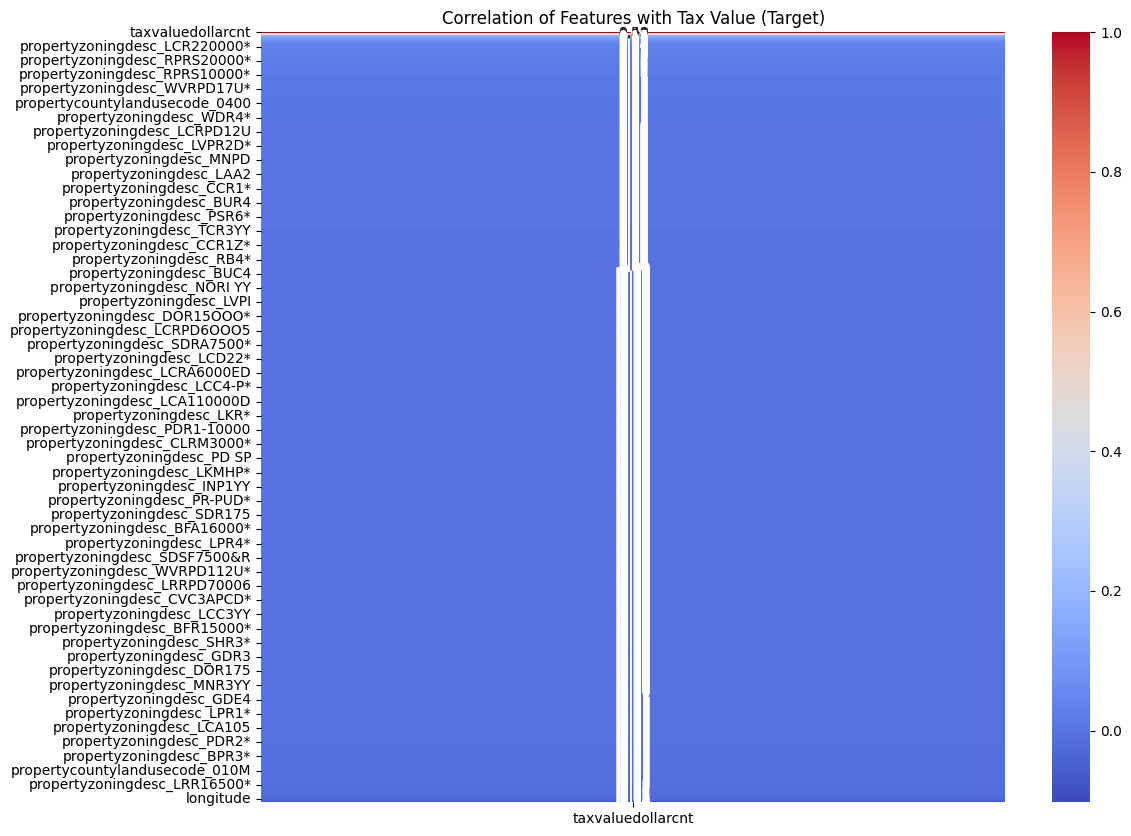

In [18]:
def drop_useless_features(df):
    high_missing = df.columns[df.isnull().mean() > 0.90]
    id_like = ['parcelid', 'censustractandblock', 'rawcensustractandblock']
    single_value = [col for col in df.columns if df[col].nunique() <= 1]
    drop_cols = list(set(high_missing) | set(id_like) | set(single_value))
    return df.drop(columns=[col for col in drop_cols if col in df.columns])

def impute_missing_values(df):
    df_imputed = df.copy()
    numeric_cols = df_imputed.select_dtypes(include=['float64', 'int64']).columns
    for col in numeric_cols:
        df_imputed[col] = df_imputed[col].fillna(df_imputed[col].median())
    cat_cols = df_imputed.select_dtypes(include='object').columns
    for col in cat_cols:
        df_imputed[col] = df_imputed[col].fillna(df_imputed[col].mode()[0])
    return df_imputed

def encode_categoricals(df):
    df_encoded = df.copy()
    cat_cols = df_encoded.select_dtypes(include='object').columns
    return pd.get_dummies(df_encoded, columns=cat_cols, drop_first=True)
df_dropped = drop_useless_features(df)
df_imputed = impute_missing_values(df_dropped)
df_cleaned = encode_categoricals(df_imputed)
corr_matrix = df_cleaned.corr()

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix[['taxvaluedollarcnt']].sort_values(by='taxvaluedollarcnt', ascending=False), 
            annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation of Features with Tax Value (Target)')
plt.show() 

#### F-statistics for feature ranking

In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import f_regression

df = pd.read_csv('zillow_dataset.csv')
def drop_unsuitable_for_regression(df):
    drop_cols = [
        'parcelid', 'assessmentyear', 'censustractandblock',
        'rawcensustractandblock', 'propertyzoningdesc',
        'propertycountylandusecode'
    ]
    return df.drop(columns=[col for col in drop_cols if col in df.columns])
def drop_useless_features(df):
    high_missing = df.columns[df.isnull().mean() > 0.90]
    id_like = ['parcelid', 'censustractandblock', 'rawcensustractandblock']
    single_value = [col for col in df.columns if df[col].nunique() <= 1]
    drop_cols = list(set(high_missing) | set(id_like) | set(single_value))
    return df.drop(columns=[col for col in drop_cols if col in df.columns])
def impute_missing_values(df):
    df_imputed = df.copy()
    numeric_cols = df_imputed.select_dtypes(include=['float64', 'int64']).columns
    for col in numeric_cols:
        df_imputed[col] = df_imputed[col].fillna(df_imputed[col].median())
    cat_cols = df_imputed.select_dtypes(include='object').columns
    for col in cat_cols:
        df_imputed[col] = df_imputed[col].fillna(df_imputed[col].mode()[0])
    return df_imputed
def encode_categoricals(df):
    df_encoded = df.copy()
    cat_cols = df_encoded.select_dtypes(include='object').columns
    return pd.get_dummies(df_encoded, columns=cat_cols, drop_first=True)
df_step1 = drop_unsuitable_for_regression(df)
df_step2 = drop_useless_features(df_step1)
df_step3 = impute_missing_values(df_step2)
df_cleaned = encode_categoricals(df_step3)
X = df_cleaned.drop(columns=['taxvaluedollarcnt'])
y = df_cleaned['taxvaluedollarcnt']
f_scores, p_values = f_regression(X, y)

f_stats_df = pd.DataFrame({
    'Feature': X.columns,
    'F-stat': f_scores,
    'p-value': p_values
}).sort_values(by='F-stat', ascending=False)
f_stats_df.head(15) 

,Feature,F-stat,p-value
6,finishedsquarefeet12,42056.629104,0.000000e+00
5,calculatedfinishedsquarefeet,39066.096081,0.000000e+00
4,calculatedbathnbr,22832.063322,0.000000e+00
9,fullbathcnt,21438.340353,0.000000e+00
1,bathroomcnt,20948.319407,0.000000e+00
2,bedroomcnt,4715.339862,0.000000e+00
3,buildingqualitytypeid,4618.625110,0.000000e+00
11,garagetotalsqft,1553.720327,0.000000e+00
10,garagecarcnt,1411.610603,3.610741e-306
24,yearbuilt,1105.595089,9.995806e-241


### Bar chart of top F-stat features

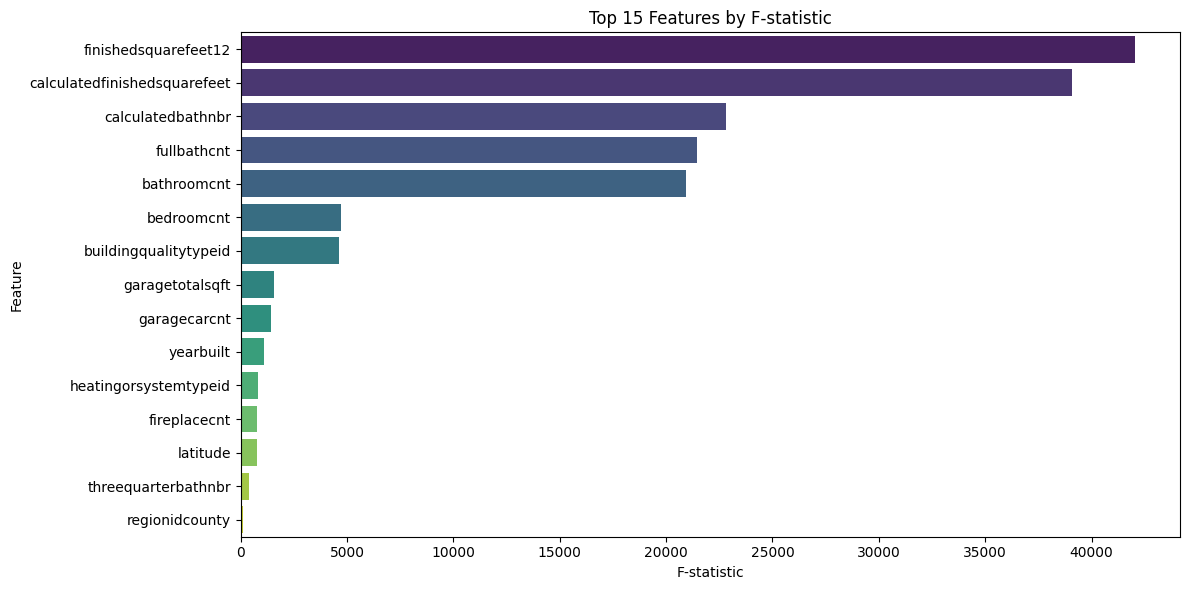

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

top_n = 15
plt.figure(figsize=(12, 6))
sns.barplot(
    data=f_stats_df.head(top_n),
    x='F-stat',
    y='Feature',
    hue='Feature', 
    palette='viridis',
    dodge=False,
    legend=False
)
plt.title(f'Top {top_n} Features by F-statistic')
plt.xlabel('F-statistic')
plt.ylabel('Feature')
plt.tight_layout()
plt.show() 

### Forward & Backward Feature Selection (Top 10 Features)

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
model = LinearRegression()
sfs_forward = SequentialFeatureSelector(
    model,
    n_features_to_select=10,
    direction='forward',
    scoring='r2',
    cv=5,  
    n_jobs=-1 
)
sfs_forward.fit(X_scaled, y)
forward_features = X.columns[sfs_forward.get_support()].tolist()
sfs_backward = SequentialFeatureSelector(
    model,
    n_features_to_select=10,
    direction='backward',
    scoring='r2',
    cv=5,
    n_jobs=-1
)
sfs_backward.fit(X_scaled, y)
backward_features = X.columns[sfs_backward.get_support()].tolist()

print("🔹 Top 10 Features (Forward Selection):")
print(forward_features)

print("\n🔸 Top 10 Features (Backward Selection):")
print(backward_features)

🔹 Top 10 Features (Forward Selection):
['bedroomcnt', 'calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'fips', 'fullbathcnt', 'garagetotalsqft', 'latitude', 'longitude', 'yearbuilt', 'numberofstories']

🔸 Top 10 Features (Backward Selection):
['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'fips', 'garagetotalsqft', 'latitude', 'longitude', 'yearbuilt', 'numberofstories']


### Summary

In this step, we explored relationships between features and the target variable taxvaluedollarcnt. Our correlation matrix showed that features such as calculatedfinishedsquarefeet, finishedsquarefeet12, and bathroom counts had strong positive correlations with the target, indicating their potential value in predictive modeling. We also computed F-statistics, which confirmed these features as having the highest linear association with the target. Additionally, we used forward and backward feature selection with linear regression to identify the top 10 features for prediction. Both selection methods consistently prioritized features related to home size, bathroom count, building quality, and garage information. These findings will help guide our modeling strategy and feature engineering choices in Milestone 2.

#### **4.A Discussion:**  Describe in a paragraph what you see in the feature relationships and correlations.

Pay particular attention to especially interesting and/or strongly correlated feature relationships. 
 How do the different methods for seeing relationships compare? Do they agree or disagree?



### Answer

We found that features like calculatedfinishedsquarefeet, finishedsquarefeet12, and bathroom counts had strong positive correlations with taxvaluedollarcnt. The correlation matrix and F-statistics largely agreed on the most important features, though F-statistics also highlighted others like garagecarcnt and buildingqualitytypeid. Forward and backward selection confirmed these patterns, with overlapping sets of top predictors. Overall, the different methods were consistent and helped us identify key features that may impact model performance.

### Part 4.B:  2-Dimensional Visualizations for Interesting Patterns  
   - Select three (3) pairs of features that exhibit meaningful relationships based on your previous analysis. 
   - Create 2D scatter plots or density plots to explore interactions between these features.  
   - Provide brief interpretations of any observed patterns or trends. 

1. Square Footage vs. Tax Value

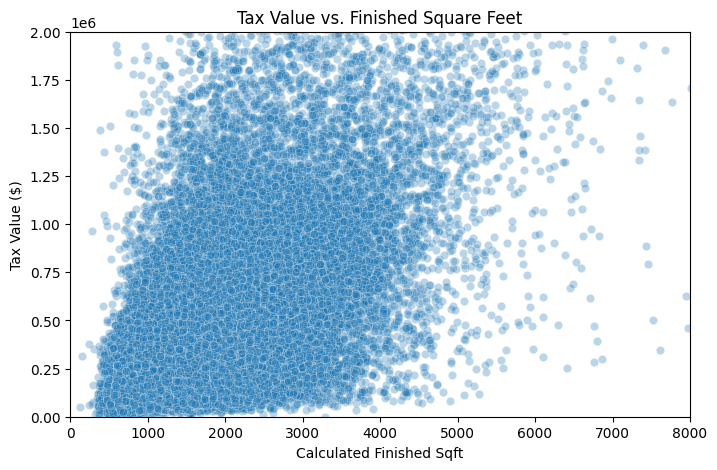

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.scatterplot(
    x=df_cleaned['calculatedfinishedsquarefeet'],
    y=df_cleaned['taxvaluedollarcnt'],
    alpha=0.3
)
plt.title('Tax Value vs. Finished Square Feet')
plt.xlabel('Calculated Finished Sqft')
plt.ylabel('Tax Value ($)')
plt.xlim(0, 8000)
plt.ylim(0, 2_000_000)
plt.show() 

### Interpretation:

There’s a clear positive trend—larger homes tend to have higher tax values. However, the spread increases at higher square footage levels, suggesting possible luxury outliers.

2. Bathroom Count vs. Tax Value

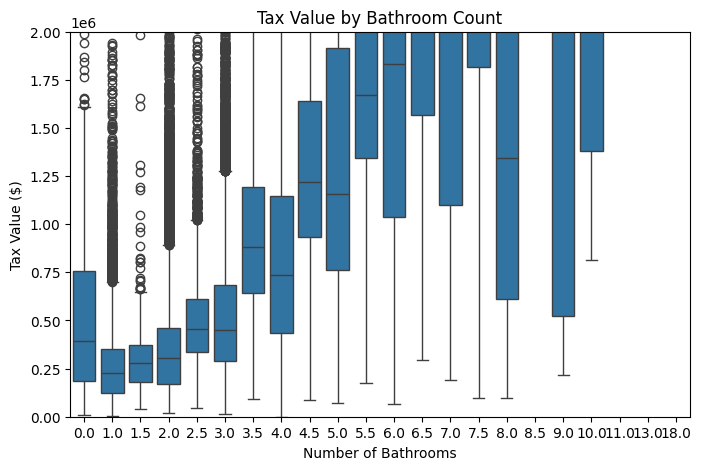

In [7]:
plt.figure(figsize=(8, 5))
sns.boxplot(
    x=df_cleaned['bathroomcnt'],
    y=df_cleaned['taxvaluedollarcnt']
)
plt.title('Tax Value by Bathroom Count')
plt.xlabel('Number of Bathrooms')
plt.ylabel('Tax Value ($)')
plt.ylim(0, 2_000_000)
plt.show() 

### Interpretation: 

Homes with more bathrooms generally have higher tax values, but the increase is not strictly linear. There's more variation for homes with 4+ bathrooms.

3. Garage Spaces vs. Tax Value

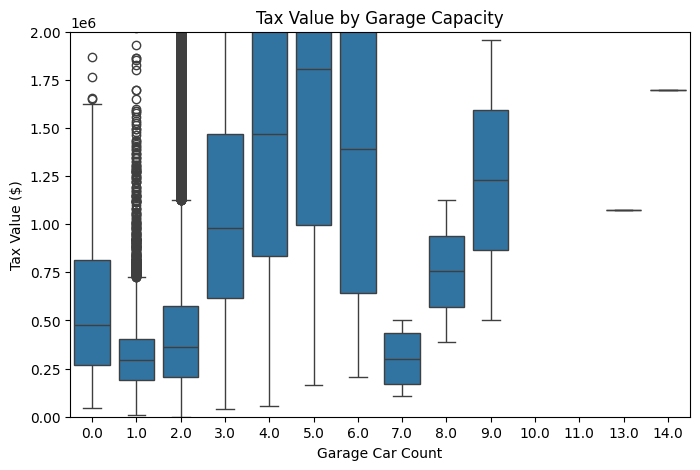

In [8]:
plt.figure(figsize=(8, 5))
sns.boxplot(
    x=df_cleaned['garagecarcnt'],
    y=df_cleaned['taxvaluedollarcnt']
)
plt.title('Tax Value by Garage Capacity')
plt.xlabel('Garage Car Count')
plt.ylabel('Tax Value ($)')
plt.ylim(0, 2_000_000)
plt.show()

### Interpretation:

Properties with more garage spaces tend to be more valuable, especially those with 2 or 3-car garages. However, the benefit plateaus beyond 3 spaces.

#### **4.B Discussion:** Provide brief interpretations of any observed patterns or trends.


In our 2D visualizations, we observed that tax value increases with finished square footage, though the relationship becomes more dispersed at higher sizes, likely due to luxury properties. Similarly, tax value generally rises with the number of bathrooms, but with diminishing returns beyond 4 bathrooms. Garage capacity also showed a positive association with tax value, especially for 2- or 3-car garages, with little added value beyond that. These patterns confirm that home size and amenities are strong indicators of property value, though the effects are not always strictly linear.

## Part 5:  Feature Engineering: Investigate various transformations to better expose the underlying data patterns to machine learning algorithms. [6 pts]

**Important Notes:**  
- This last part is a bit open ended, since there is a huge variety of feature engineering techniques, most of which won't be useful for your particular dataset. 
- Understand that you can't evaluate the final usefulness of these transformations
until you choose a model, and  models may respond differently to various transformations or obviate some transformations (e.g., ensemble methods already do feature selection). 
- Therefore, write your transformations as functions or otherwise be prepared
to choose later on which transformations may be necessary. 

**Investigate feature engineering, where appropriate:**

- Feature scaling: standardize or normalize features as necessary
- Decompose features (e.g., categorical into One-Hot feature sequence, date/time into two features data and time, etc.).
- Add promising transformations of features
    - Exponential $\exp(x_i)$ or logarithmic $\log(x_j)$
    - Polynomial features  ( $x_i^2$, $x_i - x_j$), products ($x_i*x_j$), or ratios ($x_i/x_j$)

**ToDo:**
- Pick at least three transformations to try.
- Try each one and evaluate its effect using correlations or F-scores or a feature selection algorithm.
- Answer the discussion question. 

#### **5 Discussion:** Describe in a paragraph why you chose these transformations and what you observed. 


## **Appendix 1: Features of the Zillow Dataset**  

0. **parcelid**: Unique identifier for the property parcel.  
1. **airconditioningtypeid**: Identifier for the type of air conditioning installed.  
2. **architecturalstyletypeid**: Identifier for the architectural style of the property.  
3. **basementsqft**: Square footage of the basement.  
4. **bathroomcnt**: Number of bathrooms.  
5. **bedroomcnt**: Number of bedrooms.  
6. **buildingclasstypeid**: Identifier for the building framing type (e.g., wood frame, steel frame).  
7. **buildingqualitytypeid**: Numeric value indicating the quality of the building (higher values often indicate better quality).  
8. **calculatedbathnbr**: Calculated number of bathrooms, including fractional bathrooms.  
9. **decktypeid**: Identifier for the type of deck.  
10. **finishedfloor1squarefeet**: Square footage of the finished area on the first floor.  
11. **calculatedfinishedsquarefeet**: Total finished living area square footage.  
12. **finishedsquarefeet12**: Finished living area square footage.  
13. **finishedsquarefeet13**: Perimeter living area square footage.  
14. **finishedsquarefeet15**: Total area.  
15. **finishedsquarefeet50**: Square footage of the finished area on the upper floors.  
16. **finishedsquarefeet6**: Base unfinished and finished area square footage.  
17. **fips**: Federal Information Processing Standards code, uniquely identifying counties and county equivalents.  
18. **fireplacecnt**: Number of fireplaces.  
19. **fullbathcnt**: Number of full bathrooms.  
20. **garagecarcnt**: Number of cars that can fit in the garage.  
21. **garagetotalsqft**: Total square footage of the garage.  
22. **hashottuborspa**: Indicates if the property has a hot tub or spa.  
23. **heatingorsystemtypeid**: Identifier for the type of heating system.  
24. **latitude**: Latitude coordinate of the property.  
25. **longitude**: Longitude coordinate of the property.  
26. **lotsizesquarefeet**: Lot size in square feet.  
27. **poolcnt**: Number of pools on the property.  
28. **poolsizesum**: Total square footage of all pools.  
29. **pooltypeid10**: Identifier for spa or hot tub.  
30. **pooltypeid2**: Identifier for pool with spa or hot tub.  
31. **pooltypeid7**: Identifier for pool without hot tub or spa.  
32. **propertycountylandusecode**: County land use code for the property.  
33. **propertylandusetypeid**: Identifier for the property land use type.  
34. **propertyzoningdesc**: Description of the property's zoning.  
35. **rawcensustractandblock**: Unprocessed census tract and block identifier.  
36. **regionidcity**: Identifier for the city.  
37. **regionidcounty**: Identifier for the county.  
38. **regionidneighborhood**: Identifier for the neighborhood.  
39. **regionidzip**: Identifier for the ZIP code.  
40. **roomcnt**: Total number of rooms.  
41. **storytypeid**: Identifier for the type of stories in the building (e.g., basement, attic).  
42. **threequarterbathnbr**: Number of 3/4 bathrooms (typically includes a shower but no tub).  
43. **typeconstructiontypeid**: Identifier for the type of construction (e.g., frame, masonry).  
44. **unitcnt**: Number of units in the building (e.g., for multi-family properties).  
45. **yardbuildingsqft17**: Square footage of the 17th yard building (e.g., shed).  
46. **yardbuildingsqft26**: Square footage of the 26th yard building.  
47. **yearbuilt**: Year the property was built.  
48. **numberofstories**: Number of stories in the building.  
49. **fireplaceflag**: Indicates if the property has a fireplace.  
50. **assessmentyear**: Year the property was assessed.  
51. **taxdelinquencyflag**: Indicates whether the property’s taxes are delinquent. Often “Y” if taxes are past due; otherwise null/empty.  
52. **taxdelinquencyyear**: The year in which the property’s taxes became delinquent.  
53. **censustractandblock**: A combined identifier for the property’s census tract and block group (part of the U.S. Census geographic hierarchy).  
54. **taxvaluedollarcnt**: Total assessed value of the property (land plus structure) in dollars.  


## Appendix 2: Summary of Basic Imputation Methods
Imputation depends on the data type and context. Below are common techniques for handling missing values.

---

### **1. Simple Imputation (Basic Methods)**
| Method | Best For | Code Example | Pros | Cons |
|--------|---------|--------------|------|------|
| **Drop Missing Values** | Few missing values (<5% of data) | `df.dropna()` | Quick and easy | Can remove valuable data |
| **Mean Imputation** | Normally distributed numerical data | `df.fillna(df.mean())` | Preserves mean; simple | Distorts variance, weak for skewed data |
| **Median Imputation** | Skewed numerical data | `df.fillna(df.median())` | Robust to outliers | May not capture patterns |
| **Mode Imputation** | Categorical features | `df.fillna(df.mode().iloc[0])` | Keeps most common category | Can introduce bias |
| **Constant Value (e.g., 0)** | Special cases (e.g., unknown numerical data) | `df.fillna(0)` | Simple and interpretable | Can mislead model |
| **"Unknown" Category Imputation** (**New Addition**) | Categorical features with missing values | `df.fillna('Unknown')` | Keeps all rows, prevents data loss | May introduce artificial category |

---

### **2. Statistical & Advanced Imputation**
| Method | Best For | Code Example | Pros | Cons |
|--------|---------|--------------|------|------|
| **Interpolation** | Time series, ordered data | `df.interpolate(method='linear')` | Preserves trends | May not work for non-continuous data |
| **K-Nearest Neighbors (KNN)** | Small datasets, patterns in features | `KNNImputer(n_neighbors=5).fit_transform(df)` | Uses similar observations | Computationally expensive |
| **Multivariate Imputation (MICE)** | Complex relationships between variables | `IterativeImputer().fit_transform(df)` | Captures relationships | Slower than mean/median |
| **Regression Imputation** | When missing values depend on other variables | Train regression model to predict missing values | More accurate than mean/median | Risk of overfitting |

---

### **When to Use "Unknown" Category for Categorical Imputation**
✅ **Good for:**
- Categorical features where missing values may indicate meaningful differences.  
- Customer data (e.g., missing survey responses → "No Response").  
- Product categories where missing could be a separate group.  

❌ **Avoid if:**
- The missing category does **not** have a meaningful interpretation.
- The model might learn spurious patterns from an artificial category.

---

### **Which Method to Choose?**
| Scenario | Best Method |
|----------|------------|
| **Few missing values (<5%)** | Drop NaNs (`df.dropna()`) |
| **Numerical & normal distribution** | Mean (`df.fillna(df.mean())`) |
| **Numerical & skewed distribution** | Median (`df.fillna(df.median())`) |
| **Categorical features** | Mode (`df.fillna(df.mode().iloc[0])`) |
| **Categorical with possible meaning in missingness** | "Unknown" Category (`df.fillna('Unknown')`) |
| **Small dataset with patterns** | KNN Imputer (`KNNImputer()`) |
| **Complex relationships between features** | MICE / Iterative Imputer |

